In [1]:
import matplotlib.pyplot as plt 
import pandas as pd

from molfeat.calc import FPCalculator

import numpy as np

from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

import umap

In [2]:
calc = FPCalculator("fcfp-count")

transformer = PretrainedHFTransformer(kind='Roberta-Zinc480M-102M', notation='smiles', dtype=float)

In [3]:
df = pd.read_json('./collected_data/extracted_data_collected2.json')

In [4]:
df['solvent']

0       ClC(Cl)(Cl)Cl
1           ClC(Cl)Cl
2             CC(C)=O
3            C1COCCO1
4                CC#N
            ...      
1133        CC(C)(C)O
1134        CC(C)(C)O
1135        CC(C)(C)O
1136        CC(C)(C)O
1137        CC(C)(C)O
Name: solvent, Length: 1138, dtype: object

In [5]:
df['r1'] = df['r_values'].apply(lambda x:  x['constant_1'])
df['r2'] = df['r_values'].apply(lambda x:  x['constant_2'])

In [6]:
df['r1r2'] = df['r1'] * df['r2']

In [7]:
df.dropna(subset=['monomer1', 'monomer2', 'r1r2', 'solvent'], inplace=True)
#df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]


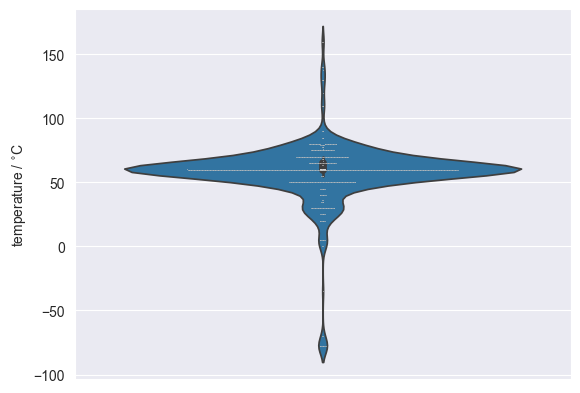

In [8]:
import seaborn as sns
fig, ax = plt.subplots()

sns.violinplot(df['temperature'], ax=ax)
sns.swarmplot(df['temperature'], ax=ax, s=.5, color='w')

ax.set_ylabel('temperature / $^{\circ}$C')

fig.savefig('temperature.pdf', bbox_inches='tight')

In [9]:
len(df)

787

In [10]:
def normalized_stdev(x):
    return abs(x.std() / x.mean())

In [11]:
grouped = df[['monomer1', 'monomer2', 'temperature', 'r1r2', 'solvent']].groupby(['monomer1', 'monomer2', 'solvent', 'temperature']).agg(['mean', 'count', 'std', normalized_stdev])

In [12]:
grouped['r1r2']['count'].value_counts()

count
1    587
2     69
3     11
4      2
5      1
Name: count, dtype: int64

In [13]:
import seaborn as sns

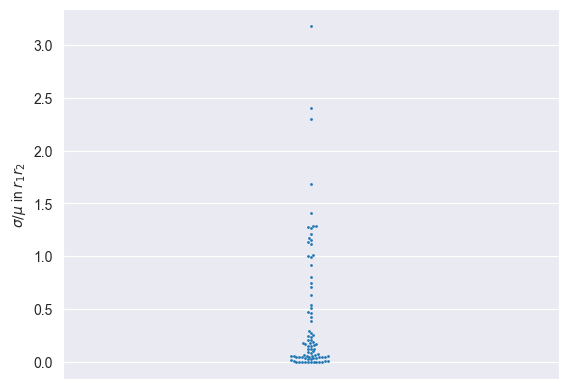

In [14]:
# plot the standard deviation in cases where count > 1
stdevs = grouped['r1r2']['normalized_stdev'].loc[grouped['r1r2']['count'] > 1]

fig, ax = plt.subplots()

sns.swarmplot(stdevs, ax=ax, s=2,)

# ax.set_yscale('symlog')
ax.set_ylabel('$\\sigma/\\mu$ in $r_1r_2$')

fig.savefig('norm_stdev_score.pdf', bbox_inches='tight')

In [15]:
# how often is the normalized stdev > 0.1

grouped['r1r2']['normalized_stdev'].loc[grouped['r1r2']['normalized_stdev'] > 0.1].sum() / len(grouped['r1r2']['normalized_stdev'])

0.052379562972634956

In [16]:
# remove cases where normalized_stdev > 0.1
grouped.fillna(0, inplace=True)
grouped_filtered = grouped[grouped['r1r2']['normalized_stdev'] < 0.1]

In [17]:
df

,file,monomer1,monomer2,r_values,conf_intervals,temperature,solvent,method,r-product,fingerprint_1,fingerprint_2,solvent_fingerprint,r-product_filter,r1,r2,r1r2
0,paper01.json,C=C(C)C(=O)O,C=Cc1ccccc1,"{'constant_1': 0.54, 'constant_2': 0.06}","{'constant_conf_1': 0.01, 'constant_conf_2': 0...",60.0,ClC(Cl)(Cl)Cl,solvent,NaN,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.54,0.06,0.0324
1,paper01.json,C=C(C)C(=O)O,C=Cc1ccccc1,"{'constant_1': 0.51, 'constant_2': 0.08}","{'constant_conf_1': 0.01, 'constant_conf_2': 0...",60.0,ClC(Cl)Cl,solvent,NaN,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.51,0.08,0.0408
2,paper01.json,C=C(C)C(=O)O,C=Cc1ccccc1,"{'constant_1': 0.43, 'constant_2': 0.65}","{'constant_conf_1': 0.0, 'constant_conf_2': 0.02}",60.0,CC(C)=O,solvent,NaN,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.43,0.65,0.2795
3,paper01.json,C=C(C)C(=O)O,C=Cc1ccccc1,"{'constant_1': 0.41000000000000003, 'constant_...","{'constant_conf_1': 0.02, 'constant_conf_2': 0...",60.0,C1COCCO1,solvent,NaN,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.41,0.59,0.2419
4,paper01.json,C=C(C)C(=O)O,C=Cc1ccccc1,"{'constant_1': 0.06, 'constant_2': 0.29}","{'constant_conf_1': 0.02, 'constant_conf_2': 0.0}",60.0,CC#N,solvent,NaN,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.06,0.29,0.0174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,paper_99.json,C=CC(=O)OCCCCCCCC,C=CC#N,"{'constant_1': 1.93, 'constant_2': 0.830000000...","{'constant_conf_1': 0.08, 'constant_conf_2': 0...",60.0,CC(C)(C)O,solvent,1.60,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.93,0.83,1.6019
1134,paper_99.json,C=CC(=O)OCCCCCCCCCCCCCCCCCC,C=CC#N,"{'constant_1': 1.74, 'constant_2': 0.68}","{'constant_conf_1': 0.04, 'constant_conf_2': 0...",60.0,CC(C)(C)O,solvent,1.18,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.74,0.68,1.1832
1135,paper_99.json,C=CC(=O)OCCCC,C=C(Cl)Cl,"{'constant_1': 0.88, 'constant_2': 0.830000000...","{'constant_conf_1': 0.1, 'constant_conf_2': 0.02}",50.0,CC(C)(C)O,solvent,NaN,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.88,0.83,0.7304
1136,paper_99.json,C=CC(=O)OCCCCCCCC,C=C(Cl)Cl,"{'constant_1': 0.87, 'constant_2': 0.700000000...","{'constant_conf_1': 0.02, 'constant_conf_2': 0...",50.0,CC(C)(C)O,solvent,NaN,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.87,0.70,0.6090


In [18]:
grouped_filtered

r1r2        \
                                                                   mean count   
monomer1              monomer2            solvent  temperature                  
C#Cc1ccccc1           C=C(C)C(=O)OC       c1ccccc1 60.0         0.09630     1   
C(=Cc1ccccc1)c1ccccc1 C1=Cc2cccc3cccc1c23 CN(C)C=O 110.0        0.14526     1   
                                                   140.0        0.07861     1   
                      C=Cc1ccccc1         CN(C)C=O 110.0        0.17061     1   
                                                   140.0        0.15906     1   
...                                                                 ...   ...   
O=c1occo1             C=CCl               CC(C)=O  80.0         0.46800     1   
                      C=CN1CCCC1=O        CC(C)=O  60.0         0.28000     1   
                      C=COC(C)=O          CC(C)=O  70.0         0.81000     1   
                                          c1ccccc1 60.0         0.94900     1   
                      C=CSC               c1ccccc1 60.0         0.53000     1   

                                                                     \
                                                                std   
monomer1              monomer2            solvent  temperature        
C#Cc1ccccc1           C=C(C)C(=O)OC       c1ccccc1 60.0         0.0   
C(=Cc1ccccc1)c1ccccc1 C1=Cc2cccc3cccc1c23 CN(C)C=O 110.0        0.0   
                                                   140.0        0.0   
                      C=Cc1ccccc1         CN(C)C=O 110.0        0.0   
                                                   140.0        0.0   
...                                                             ...   
O=c1occo1             C=CCl               CC(C)=O  80.0         0.0   
                      C=CN1CCCC1=O        CC(C)=O  60.0         0.0   
                      C=COC(C)=O          CC(C)=O  70.0         0.0   
                                          c1ccccc1 60.0         0.0   
                      C=CSC               c1ccccc1 60.0         0.0   

                                                                                 
                                                               normalized_stdev  
monomer1              monomer2            solvent  temperature                   
C#Cc1ccccc1           C=C(C)C(=O)OC       c1ccccc1 60.0                     0.0  
C(=Cc1ccccc1)c1ccccc1 C1=Cc2cccc3cccc1c23 CN(C)C=O 110.0                    0.0  
                                                   140.0                    0.0  
                      C=Cc1ccccc1         CN(C)C=O 110.0                    0.0  
                                                   140.0                    0.0  
...                                                                         ...  
O=c1occo1             C=CCl               CC(C)=O  80.0                     0.0  
                      C=CN1CCCC1=O        CC(C)=O  60.0                     0.0  
                      C=COC(C)=O          CC(C)=O  70.0                     0.0  
                                          c1ccccc1 60.0                     0.0  
                      C=CSC               c1ccccc1 60.0                     0.0  

[623 rows x 4 columns]

In [19]:
# now, flatten the columns to get rid of the multiindex, keep only the "mean" aggregation

mean_columns = grouped_filtered.xs('mean', axis=1, level=1)
mean_columns.columns = mean_columns.columns.get_level_values(0)

In [20]:
mean_columns.reset_index(inplace=True)

In [21]:
#df = df[df['r1r2']>=0]
mean_columns = mean_columns[mean_columns['r1r2']>=0]

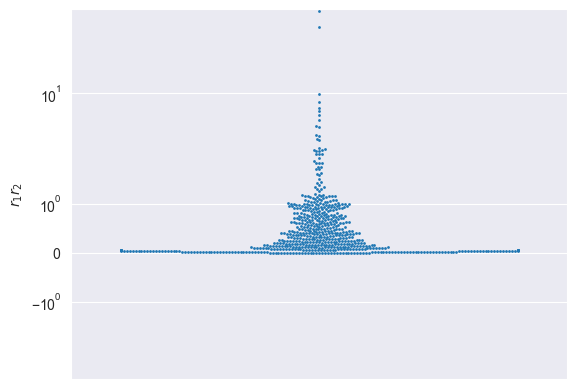

In [22]:
# plot basic distributions of dataset 

fig, ax = plt.subplots()

sns.swarmplot(mean_columns['r1r2'], ax=ax, s=2,)

ax.set_yscale('symlog')

ax.set_ylabel('$r_1r_2$')

fig.savefig('r1r2.pdf', bbox_inches='tight')

In [23]:
monomer1_fps = np.stack(mean_columns['monomer1'].apply(calc).values)
#monomer_1_features = np.stack(df['monomer1'].apply(transformer.transform).values)

[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerat

In [24]:
monomer2_fps = np.stack(mean_columns['monomer2'].apply(calc).values)

[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerat

In [25]:
solvent_fps = np.stack(mean_columns['solvent'].apply(calc).values)

[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerator
[10:29:47] DEPRECATION WARNING: please use MorganGenerat

In [26]:
sum_fp =  monomer1_fps + monomer2_fps 

prod_fp = monomer1_fps * monomer2_fps

In [27]:
fingerprints = np.hstack([sum_fp, solvent_fps, mean_columns['temperature'].values.reshape(-1,1)]) # solvent_fps, mean_columns['temperature'].values.reshape(-1,1)

In [28]:
labels = mean_columns['r1r2']

In [29]:
all_smiles = set(mean_columns['monomer1'].values.tolist() + mean_columns['monomer2'].values.tolist())

In [30]:
train_smiles, test_smiles = train_test_split(list(all_smiles), test_size=0.5)


In [31]:
len(train_smiles)

136

In [32]:
len(test_smiles)

136

In [33]:
train_idx = np.where((mean_columns['monomer1'].isin(train_smiles) | mean_columns['monomer2'].isin(train_smiles)).values)[0]

# if not in train set, it is in test set
test_idx = np.where((~mean_columns['monomer1'].isin(train_smiles) & ~mean_columns['monomer2'].isin(train_smiles)).values)[0]


In [34]:
len(test_idx)

104

In [35]:
len(train_idx)

509

In [36]:
tolerance = 0.1
high_threshold = 10

classes = []

# r1r2 = 0
# 0 < r1r2 < 1
# r1r2 = 1
# 1 < r1r2

# for label in labels.values:
#     if -tolerance <= label <= tolerance:
#         classes.append(0)
#     elif 0 + tolerance < label <= 1 - tolerance:
#         classes.append(1)
#     elif 1-tolerance < label <= 1 + tolerance:
#         classes.append(2)
#     elif 1 + tolerance< label:
#         classes.append(3)

for label in labels.values:
    if label < tolerance:
    #if label > 1 + tolerance:   
        classes.append(1)
    else: 
        classes.append(0)

In [37]:
from collections import Counter

Counter(classes)

classes = np.array(classes)

In [38]:
# train_fingerprints, test_fingerprints, train_labels, test_lables = train_test_split(fingerprints, labels, test_size=0.2)

train_fingerprints = fingerprints[train_idx]
test_fingerprints = fingerprints[test_idx]

train_labels = classes[train_idx]
test_lables = classes[test_idx]

In [39]:
model = HistGradientBoostingClassifier(max_iter=500, class_weight={0:1, 1:50})
model.fit(train_fingerprints, train_labels)

HistGradientBoostingClassifier(class_weight={0: 1, 1: 50}, max_iter=500)

In [40]:
predictions = model.predict(test_fingerprints)

In [41]:
from pycm import ConfusionMatrix

In [42]:
cm = ConfusionMatrix(actual_vector=test_lables, predict_vector=predictions)

In [43]:
print(cm)

Predict  0        1        
Actual
0        57       12       

1        17       18       





Overall Statistics : 

95% CI                                                            (0.63497,0.80734)
ACC Macro                                                         0.72115
ARI                                                               0.17395
AUNP                                                              0.67019
AUNU                                                              0.67019
Bangdiwala B                                                      0.58041
Bennett S                                                         0.44231
CBA                                                               0.64228
CSI                                                               0.35532
Chi-Squared                                                       13.10711
Chi-Squared DF                                                    1
Conditional Entropy                                          

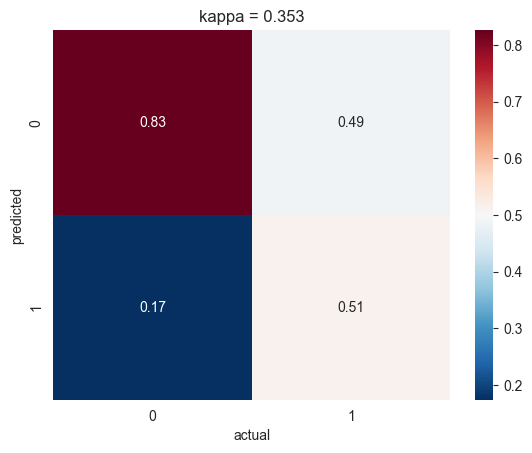

In [44]:
sns.heatmap(pd.DataFrame(cm.normalized_matrix), annot=True, cmap='RdBu_r')
plt.title("kappa = {:.3}".format(cm.Kappa))
plt.ylabel('predicted')
plt.xlabel('actual')
plt.savefig('confusion_0_01.pdf', bbox_inches='tight')

In [45]:
label_transformer = PowerTransformer(standardize=True)
model = HistGradientBoostingRegressor(max_iter=500)

In [46]:

train_fingerprints = fingerprints[train_idx]
test_fingerprints = fingerprints[test_idx]

train_labels = labels.values[train_idx]
test_lables = labels.values[test_idx]

In [47]:
train_labels = label_transformer.fit_transform(train_labels.reshape(-1,1))
test_lables = label_transformer.transform(test_lables.reshape(-1,1))    

In [48]:
train_labels = np.sqrt(train_labels)
test_lables = np.sqrt(test_lables)

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_21143/2245411778.py:1: RuntimeWarning: invalid value encountered in sqrt
  train_labels = np.sqrt(train_labels)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_21143/2245411778.py:2: RuntimeWarning: invalid value encountered in sqrt
  test_lables = np.sqrt(test_lables)


In [49]:
model.fit(train_fingerprints, train_labels)

/Users/maraw/anaconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input y contains NaN.

In [ ]:
predictions = model.predict(test_fingerprints)

In [ ]:
plt.scatter(test_lables, predictions, s=1)
plt.xlim(0,5)

In [ ]:
r2_score(test_lables, predictions)

In [ ]:
plt.hist(train_labels)

In [ ]:
plt.hist(np.sqrt(df['r1r2']), bins=100)

In [ ]:
reducer = umap.UMAP(n_neighbors=50)

In [ ]:
scaled_data = StandardScaler().fit_transform(fingerprints)

In [ ]:
#reducer = PCA(n_components=2)
reduced = reducer.fit_transform(scaled_data)

In [ ]:
classes = []

# 0 == r1r2
# 0 < r1r2 < 1
# 1 == r1r2
# r1r2>1

for r1r2 in df['r1r2']:
    if 0.01 < r1r2 < 1:
        classes.append(0)
    elif r1r2 > 1:
        classes.append(1)
    elif r1r2 == 1:
        classes.append(2)
    elif r1r2 <= 0.01:
        classes.append(3)
# 
labels = np.array(classes)

In [ ]:
plt.scatter(reduced[:,0], reduced[:,1], c=classes, s=.5,  alpha=.5)
plt.xlim(0,20)

In [ ]:
plt.hist(labels)

In [ ]:
precision_frame = pd.read_json('selected_entries-1718346698792.json')

In [ ]:
fig, ax = plt.subplots()

sns.swarmplot(precision_frame['precision'], ax=ax, s=2,)

fig.savefig('precision.pdf', bbox_inches='tight')